In [1]:
%pylab inline

from PyTools import integrated_flux
import os, pres_style

def mag2flux(mag, wlength):
    return 10**(-0.4 * (mag - 22.5)) * 3.631e-6 * 1e-23 * (299792458.0E10/wlength**2)
def flux2mag(flux, wlength):
    return -2.5*log10(flux / 3.631e-6 / 1e-23 / (299792458.0E10/wlength**2)) + 22.5

Populating the interactive namespace from numpy and matplotlib


In [2]:
odir = "../inputs/real_deal7/"

u_obf, g_obf, r_obf, i_obf, z_obf, rs_sam = loadtxt("data/Samples/ugriz_catalog_of.txt", usecols=range(1, 6)+[11],
                                                    unpack=True)
u_ref, g_ref, r_ref, i_ref, z_ref = loadtxt("data/Samples/ugriz_catalog_rf.txt", usecols=range(1, 6), unpack=True)

knames = loadtxt("data/Samples/ugriz_catalog_rf.txt", dtype=str, usecols=(0,))
mnames = loadtxt("data/RealDeal/rd7_master.txt", dtype=str)
snames = loadtxt("data/RealDeal/rd7_sample.txt", dtype=str)

weff = array([3.5618E+03, 4.7189E+03, 6.1852E+03, 7.4997E+03, 8.9615E+03])
sdss_res = loadtxt("../inputs/SDSS_filters.txt")
u_res = sdss_res[:47]
g_res = sdss_res[47:47+89]
r_res = sdss_res[47+89:47+89+75]
i_res = sdss_res[47+89+75:47+89+75+89]
z_res = sdss_res[47+89+75+89:]

In [3]:
#now remove galaxies not in the actual sample
knames_in_snames = array([name in snames for name in knames], dtype=bool)
mnames_in_snames = array([name in snames for name in mnames], dtype=bool)

print "all tables matching? ", all(knames[knames_in_snames]==snames) & all(mnames[mnames_in_snames]==snames)

most_rs = rs_sam[knames_in_snames]>=0.09
most_rs[where(most_rs)[0][2000:]] = False # take only the first 1000 galaxies

all tables matching?  True


In [4]:
icolor_x = u_obf[knames_in_snames] - g_obf[knames_in_snames]
icolor_y = g_obf[knames_in_snames] - r_obf[knames_in_snames]
kcolor_x = u_ref[knames_in_snames] - g_ref[knames_in_snames]
kcolor_y = g_ref[knames_in_snames] - r_ref[knames_in_snames]

icolor_z = g_obf[knames_in_snames] - i_obf[knames_in_snames]
kcolor_z = g_ref[knames_in_snames] - i_ref[knames_in_snames]

redshift = rs_sam[knames_in_snames]

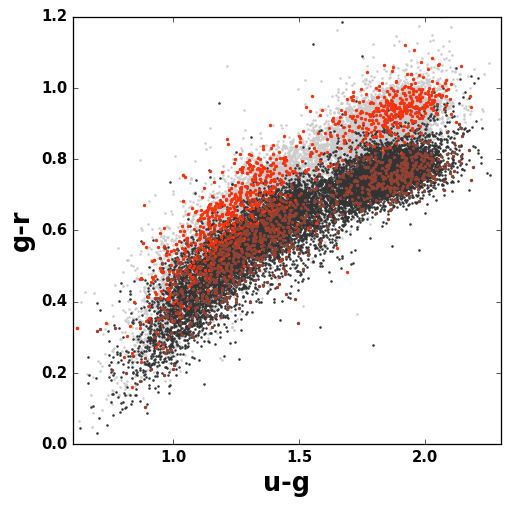

In [5]:
xlm = array((0.6, 2.3))
ylm = array((0.0, 1.2))
axs = subplot(111, xlim=xlm, ylim=ylm)

scatter(icolor_x, icolor_y, lw=0, c="0.8", s=4)
scatter(kcolor_x, kcolor_y, lw=0, c="0.2", s=4)

scatter(icolor_x[most_rs], icolor_y[most_rs], lw=0, c="#F9320C", s=7)
scatter(kcolor_x[most_rs], kcolor_y[most_rs], lw=0, c="#904233", s=7)

xlabel("u-g")
ylabel("g-r")

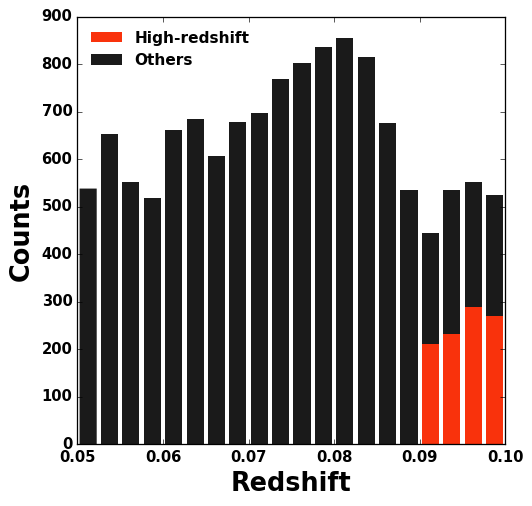

In [6]:
hist([redshift[most_rs], redshift[~most_rs]], 20, histtype="barstacked", color=["#F9320C", "0.1"],
     label=["High-redshift", "Others"])
legend(loc=0, fontsize=12)

xlabel("Redshift")
ylabel("Counts")

In [7]:
vnames, sdss, spec = [], [], []
band = [g_res, r_res, i_res]
for file in snames[most_rs]:
    kflux = loadtxt(odir+"sdss/"+"processed_SDSS_"+file.replace("fit", "txt"), usecols=(1,))
    
    SED = loadtxt(odir+"spec/"+"processed_SPEC_"+file.replace("fit", "txt"), usecols=(0, 1))
    sflux = array([integrated_flux(SED[SED[:, 1]>0.0, :], b) for b in band])

    vnames.append(file)
    sdss.append(kflux)
    spec.append(sflux)

vnames = array(vnames, dtype=str)
sdss = array(sdss)
spec = array(spec)
diff = array([(sdss[:, j+1]/sdss[:, 2]-spec[:, j]/spec[:, 1])*100.0/(spec[:, j]/spec[:, 1]) for j in [0, 2]])

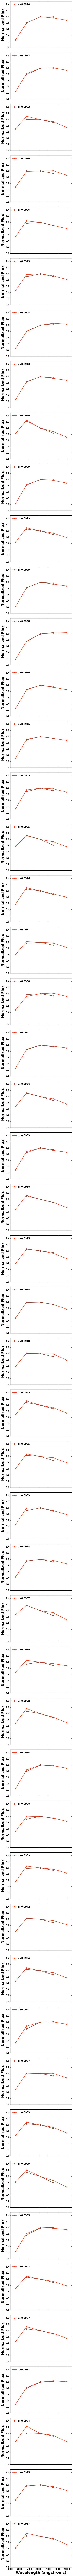

In [8]:
N = 50
fig, axs = subplots(N, 1, sharex=True, sharey=True, figsize=(6, 4*N))

xlim(3000, 9500)
ylim(0.0, 1.5)

for j in xrange(N):
    axs[j].plot(weff, sdss[j]/sdss[j, 2], "o-", color="#F9320C", label="z={0:.4f}".format(redshift[most_rs][j]))
    axs[j].plot(weff[1:-1], spec[j]/spec[j, 1], "o-", color="#904233")

    axs[j].set_ylabel("Normalized Flux")
    axs[j].legend(loc=2, fontsize=12)

xlabel("Wavelength (angstroms)")

fig.tight_layout()

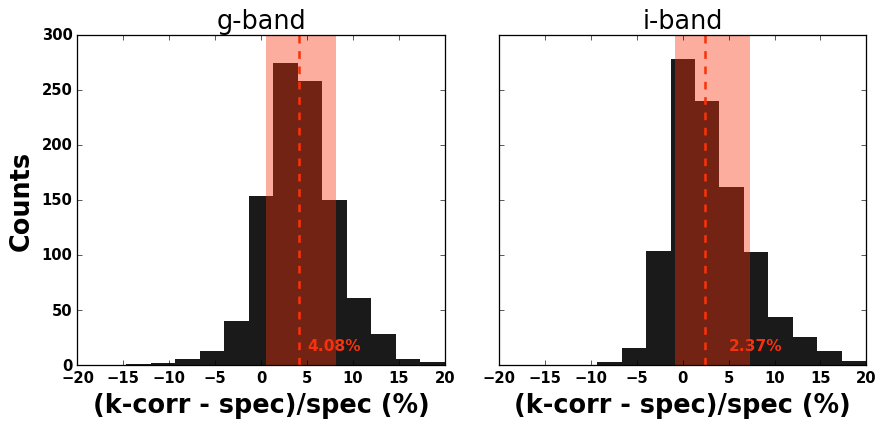

In [35]:
fig, axs = subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

nband = ["g-band", "i-band"]
for j in xrange(axs.size):
    p16, p84 = percentile(diff[j], [16., 84.])
    med = median(diff[j])

    axs[j].hist(diff[j], 15, range=(-20,+20), fc="0.1")
    axs[j].axvspan(p16, p84, fc="#F9320C", alpha=0.4)
    axs[j].axvline(med, ls="--", color="#F9320C")
    
    axs[j].text(5, 25, "{0:.2f}%".format(med), ha="left", va="top", color="#F9320C", size=12)
    
    axs[j].set_title(nband[j])
    axs[j].set_xlabel("(k-corr - spec)/spec (%)")

axs[0].set_ylabel("Counts")

fig.tight_layout()

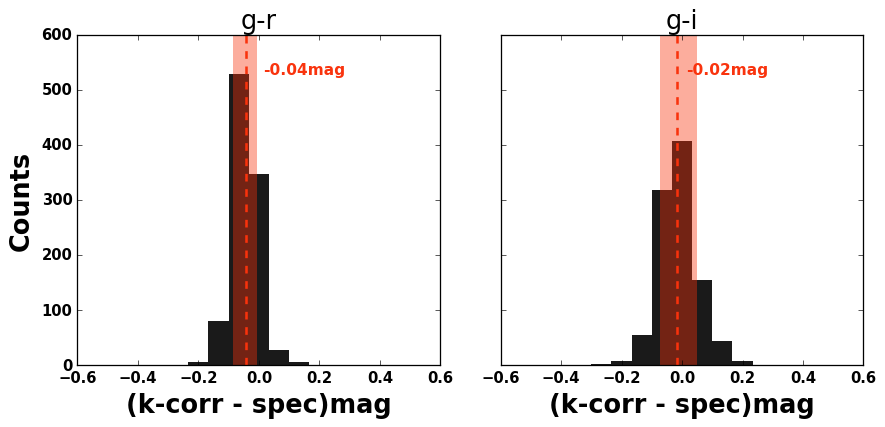

In [34]:
scolor_y = flux2mag(spec[:, 0], weff[1]) - flux2mag(spec[:, 1], weff[2])
scolor_z = flux2mag(spec[:, 0], weff[1]) - flux2mag(spec[:, 2], weff[3])

fig, axs = subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

ncol = ["g-r", "g-i"]
col = [kcolor_y[most_rs] - scolor_y, kcolor_z[most_rs] - scolor_z]
for j in xrange(axs.size):
    p16, p84 = percentile(col[j], [16., 84.])
    med = median(col[j])

    axs[j].hist(col[j], 15, range=(-0.5,+0.5), fc="0.1")
    axs[j].axvspan(p16, p84, fc="#F9320C", alpha=0.4)
    axs[j].axvline(med, ls="--", color="#F9320C")
    
    axs[j].text(0.15, 550, "{0:.2f}mag".format(med), ha="center", va="top", color="#F9320C", size=12)
    
    axs[j].set_title(ncol[j])
    axs[j].set_xlabel("(k-corr - spec)mag")

axs[0].set_ylabel("Counts")

fig.tight_layout()